## Preparing the enviornment¶
There are some packages that need to be installed before running the codes. Which can be find in binder/requirements.txt file.

# Introduction

This jupyter book presents an introduction to brain decoding and encoding using functional magnetic resonance imaging (fMRI) data. 

Brain decoding or mind-reading using neuroimaging data has been an active topic for years. It is a neuroscience field that concerned about different types of stimuli from information that has already been encoded and represented in the brain by networks of neurons. 

Brain decoding models are type of models that try to predict what a subject is doing or what kind of stimuli was presented to them, based on recordings of brain activity. One way is considering the blood-oxygen-level-dependent (BOLD) signal, which are detected by fMRI scanners. These signals reflect the change of oxygen level in the different brain regions.

In [1]:
import os
import sys
import torch
import glob
import pandas as pd
import numpy as np
import pathlib
import keras
import nilearn.connectome
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

sys.path.append(os.path.join(".."))
sys.path.append('../src')
import gcn_windows_dataset
import graph_construction
import gcn_model
import visualization

import warnings
warnings.filterwarnings(action='once')

/home/SRastegarnia/.virtualenvs/hcptrtr_gcn_env/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Fetching Haxby dataset

In this notebook, all the models are trained on the *Haxby et al. (2001) data set* which is a high-quality block-design fMRI dataset from a study on face & object representation in the human ventral temporal cortex (involved in the high-level visual processing of complex stimuli). The data set consisted of 6 subjects and 12 runs for each, but for the tutorial session we are fetch just one of the subjects.

Dataset can be download using the following command:

__*haxby_ds = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)*__

Also, We could easily removed resting state tasks at the time of selecting data. That would give us higher accuracy results.

__*X = masker.fit_transform(func_file)[nonrest_task_mask]* \
*y = labels['labels'][nonrest_task_mask]*__

The event design labels in this dataset are visual stimulus including:
- *'face', 'chair', 'scissors', 'shoe', 'scrambledpix', 'house', 'cat', 'bottle' and 'rest'*

An examples of stimuli in Haxby dataset is as follow:
<img src="Haxby_stimuli.png" width=250 height=170 />

In [2]:
# We have already fetched the data for subject 4
data_dir = os.path.join('..', 'data')
raw_data_dir = os.path.join(data_dir, 'haxby2001','subj4')
func_file = os.path.join(raw_data_dir,'bold.nii.gz')
session_target = os.path.join(raw_data_dir,'labels.txt')

# Standardizing
mask_vt_file = os.path.join(raw_data_dir,'mask4_vt.nii.gz')
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)

labels = pd.read_csv(session_target, sep=" ")

# Selecting data
X = masker.fit_transform(func_file)
y = labels['labels']

## Checking the data
Here we see the shape and the labels (it can be called also features or unique conditions) of this data sample, which is necessary to check before start training any decoding model!

In [3]:
categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


## Support vector machine (SVM)
In the following cells, we will train *SVM classifier* which is usually very successful in high dimensional spaces.

Support vector machines (SVMs) are a set of supervised learning models that are mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in N-dimensional space that N depends on the number of features that distinctly classify the data points (e.g. when the number of features is 3 the hyperplane becomes a two-dimensional plane.). The objective here is finding a hyperplane (decision boundaries that help classify the data points) with the maximum margin (i.e the maximum distance between data points of both classes). Data points falling on either side of the hyperplane can be attributed to different classes.

__Pros:__
- Effective in high dimensional spaces even when the number of dimensions is greater than the number of samples.
- Memory efficient
- Different Kernel functions can be specified for the decision function.


__Cons:__
- Risk of overfitting when the number of features is much greater than the number of samples. (can be avoided by choosing Kernel functions and regularization term).
- SVMs do not provide probability estimates directly. (can be calculated using five-fold cross-validation.)

We are aiming to run an SVM model with:
- 10 folds cross validation
- 20% test size

In [4]:
# Selecting data
X = masker.fit_transform(func_file)
y = labels['labels']

# Encoding the string to numerical values
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)   

# prepare the cross-validation procedure
cv = KFold(n_splits = 10, random_state = 0, shuffle = True)

# Initializing the SVM model
model_svm = SVC(decision_function_shape = 'ovo', random_state = 0, kernel='linear')
# model_svm.fit(X_train, y_train)

# evaluate model
scores = cross_val_score(model_svm, X_test, y_test, 
                         scoring = 'accuracy', cv = cv, n_jobs = -1)    
y_pred = cross_val_predict(model_svm, X_test, y_test, cv = cv)
report = classification_report(y_test, y_pred)

print(report)
print(scores)
print('mean accuracy:%.4f' % np.mean(scores))

              precision    recall  f1-score   support

           0       0.32      0.52      0.39        23
           1       0.47      0.40      0.43        20
           2       0.26      0.33      0.29        18
           3       0.84      0.78      0.81        27
           4       0.82      0.53      0.64        17
           5       0.88      0.88      0.88       117
           6       0.33      0.26      0.29        27
           7       0.69      0.61      0.65        18
           8       0.43      0.42      0.43        24

    accuracy                           0.64       291
   macro avg       0.56      0.53      0.53       291
weighted avg       0.66      0.64      0.65       291

[0.6        0.51724138 0.62068966 0.75862069 0.68965517 0.72413793
 0.68965517 0.5862069  0.62068966 0.62068966]
mean accuracy:0.6428


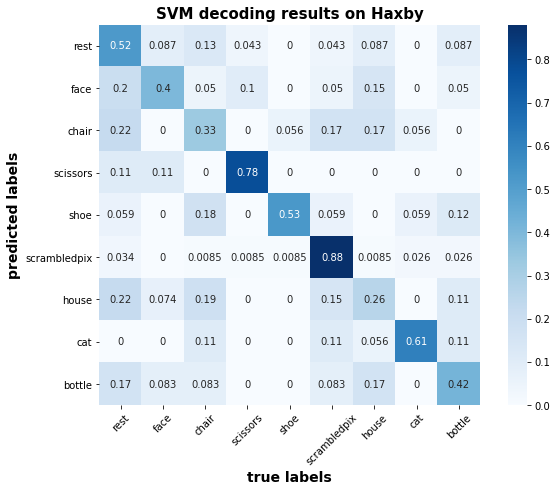

In [5]:
# confusion matrix
cm_svm = confusion_matrix(y_test, y_pred)
model_conf_matrix = cm_svm.astype('float') / cm_svm.sum(axis = 1)[:, np.newaxis]

visualization.conf_matrix(model_conf_matrix, 
                          categories, 
                          title='SVM decoding results on Haxby')

# Multilayer Perceptron (MLP)



__*What is an artificial neural network (ANN)?*__

ANN is the foundation of AI and one of the main tools used in ML inspired by the human brain when networks of neurons analyze and process information. ANNs have self-learning capabilities and can learn from their experience that enabling them to produce better results as more data becomes available. Neural networks consist of input and output layers also in most cases there exist hidden layer(s) that transforms the input to the usable data for the output layer. ANN initially goes through a training phase. During this supervised phase, the network is taught what to look for and what is the desired output.

In this part, we are going to train a model called __Multilayer Perceptron__ for supervised learning. The simple form on this model with just one hidden layer is sometimes called "vanilla" neural networks. Basicly the simplest model at least consisted of three following layers: 
* onr input layer
* onr hidden layer
* one output layer.

Similar to the previous approach in this section we aim to predict that the time-series input belongs to which specific class but this time by running MLP model. The model we are going to train consisted of:

- with 2 dense layers
- 10 fold cross validation
- 20% test size

__*What is cross-validation and why we need it?*__
Basically, this method is used to test the capability of an ML model for predicting new data which also can help some other probable issues that might happen during training a model such as overfitting or bias selection.

1. During cross-validation process the dataset will be shuffle randomly and after that it will be splited into k groups
2. For each seperate group of the firt procidure on test set will be chosen and the rest will be considered as training set.
3. Then the model will be fitted on the training set and will be evaluated on the test set

In [6]:
# Encoding the string to numerical values.
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

# reshapeing y
temp = np.reshape(y, (len(y),1))
y = temp

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)
y = pd.DataFrame(enc.fit_transform(y).toarray())
y

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1447,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1448,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1449,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1450,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Split dataset
We will shuffle and split the data into training and test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 0)

#standarize features caling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Initializing the model

In [8]:
# number of unique conditions that we have
mlp_classifier = Sequential()

# Adding the input layer and the first hidden layer
mlp_classifier.add(Dense(338 , input_dim = 675, kernel_initializer="uniform", activation = 'relu'))

# Adding the second hidden layer
mlp_classifier.add(Dense(169, kernel_initializer="uniform", activation = 'relu'))

# Using softmax at the end, lenght of categories shows the number of labels we have
mlp_classifier.add(Dense(len(categories), activation = 'softmax'))

In [9]:
mlp_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 338)               228488    
_________________________________________________________________
dense_1 (Dense)              (None, 169)               57291     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1530      
Total params: 287,309
Trainable params: 287,309
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compiling the model
mlp_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
# Fitting the model on the Training set
history = mlp_classifier.fit(X_train, y_train, batch_size = 10,
                             epochs = 10, validation_split = 0.2)

Epoch 1/10
93/93 [==============================] - 1s 8ms/step - loss: 1.4907 - accuracy: 0.5065 - val_loss: 1.4183 - val_accuracy: 0.4979
Epoch 2/10
93/93 [==============================] - 1s 6ms/step - loss: 0.8900 - accuracy: 0.7091 - val_loss: 1.0807 - val_accuracy: 0.6395
Epoch 3/10
93/93 [==============================] - 1s 6ms/step - loss: 0.5255 - accuracy: 0.8233 - val_loss: 1.0858 - val_accuracy: 0.6867
Epoch 4/10
93/93 [==============================] - 1s 6ms/step - loss: 0.3450 - accuracy: 0.8922 - val_loss: 1.0694 - val_accuracy: 0.6738
Epoch 5/10
93/93 [==============================] - 1s 6ms/step - loss: 0.2465 - accuracy: 0.9159 - val_loss: 1.0302 - val_accuracy: 0.6996
Epoch 6/10
93/93 [==============================] - 1s 6ms/step - loss: 0.1595 - accuracy: 0.9483 - val_loss: 0.9301 - val_accuracy: 0.7253
Epoch 7/10
93/93 [==============================] - 1s 6ms/step - loss: 0.1907 - accuracy: 0.9310 - val_loss: 0.9956 - val_accuracy: 0.7511
Epoch 8/10
93/93 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


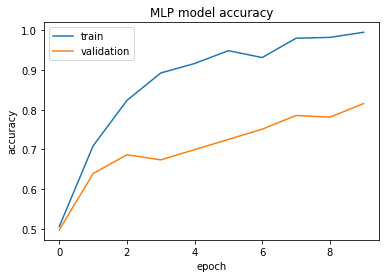

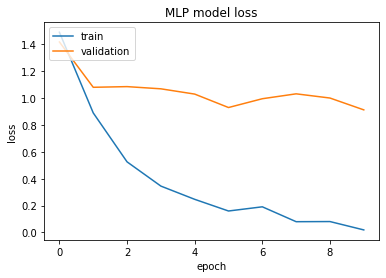

In [12]:
plot_history = visualization.classifier_history (history, 'MLP ')

mean accuracy score: 0.82


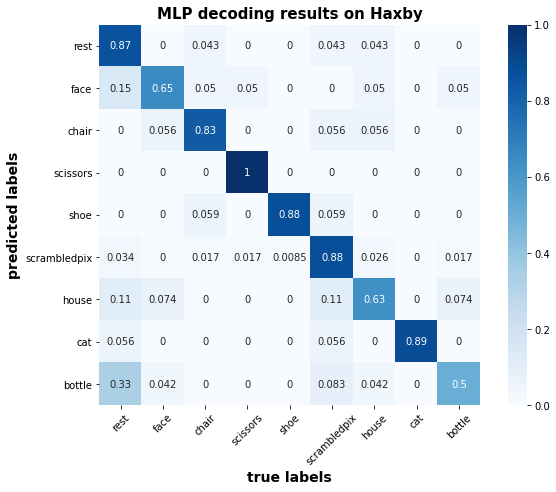

In [13]:
# Making the predictions and evaluating the model
y_pred = mlp_classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print ('mean accuracy score:', np.round(accuracy_score(y_test.values.argmax(axis = 1), 
                                                       y_pred.argmax(axis=1), normalize = True, 
                                                       sample_weight=None),2))

# Confusion matrix
cm_mlp = confusion_matrix(y_test.values.argmax(axis = 1), y_pred.argmax(axis=1))
model_conf_matrix = cm_mlp.astype('float') / cm_mlp.sum(axis = 1)[:, np.newaxis]

visualization.conf_matrix(model_conf_matrix, 
                          categories, 
                          title='MLP decoding results on Haxby')

# Graph Convolutional Networks (GCN)

### Model pipeline:
- Takes a short series of fMRI volumes as input.
- Maps the fMRI signals onto a predefined brain graph.
- Propagates brain dynamics information on inter-connected brain regions & networks.
- Generates task-specific representations of recorded brain activities. 
- Predicts the corresponding task states.


- __6__ graph convolutional layers
- __32 graph filters__  at each layer
- followed by a __global average pooling__ layer
- __2 fully connected__ layers 

<img src="GCN_pipeline.png" width=850 height=420 />

## Data paths

In [14]:
proc_path = os.path.join(data_dir, 'haxby_proc/')
concat_path = os.path.join(data_dir, 'haxby_concat/')
conn_path = os.path.join(data_dir, 'haxby_connectomes/')
split_path = os.path.join(data_dir, 'haxby_split_win/')

## Generating connectomes

In [15]:
# Estimating connectomes
corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = corr_measure.fit_transform([X])[0]

# np.save(os.path.join(conn_path, 'conn_subj{}.npy'.format(sub_no)), conn)

conn_files = sorted(glob.glob(conn_path + '/*.npy'))

## Split dataset

Here we will split the processed data into three diferent sets for train, validation, and test.

In [16]:
random_seed = 0

train_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="train"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True,
    shuffle = True)

valid_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="valid"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, 
    shuffle = True)

test_dataset = gcn_windows_dataset.TimeWindowsDataset(
    data_dir=split_path
    , partition="test"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, 
    shuffle = True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 1016*(torch.Size([675, 1]), ())
valid dataset: 290*(torch.Size([675, 1]), ())
test dataset: 146*(torch.Size([675, 1]), ())


In [17]:
torch.manual_seed(random_seed)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([16, 675, 1]); mean -6.18122220075179e-09
Labels batch shape: torch.Size([16]); mean 3.6875


## Getting connectomes
We will get the average connectome.

In [18]:
connectomes = []
for conn_file in conn_files:
      connectomes += [np.load(conn_file)]

## Building brain graphs

After loading brain connectome, we will build brain garph.
__k-Nearest Neighbours(KNN) graph__ for the group average connectome will be built based on the connectivity-matrix.

Each node is only connected to *k* other neighbours, which is __8 nodes__ with the strongest regions connectivity in this experiment.

For more details you please check out __*src/graph_construction.py*__ script.

In [19]:
graph = graph_construction.make_group_graph(connectomes, self_loops=False, 
                                            k=8, symmetric=True)

## Running model

__*Time windows*__

For the GCN model in order to run the model on different sizes of input, we will concatenate bold data of the same stimuli and save it in a single file.

It means that we need to extract the fmri time-series for each trial using the event design labels.

Different lengths for our input data can be selected. 
In this example we will continue with __*window_length = 1*__, which means each input file will have a length equal to just one Repetition Time (TR).

TR is cycle time between corresponding points in fMRI.

In [20]:
window_length = 1
gcn = gcn_model.GCN(graph.edge_index, graph.edge_attr, 
                           n_timepoints=window_length)
gcn

GCN(
  (conv1): ChebConv(1, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 16, K=2, normalization=sym)
  (fc1): Linear(in_features=10800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=21, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train and evaluating the model

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

## Start training
We will repeat the process for 15 epochs (times), and will evaluate the model based on the average accuracy and loss of these epochs.

In [22]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Epoch 1/15
-------------------------------
#    0;	train_loss: 3.090;	train_accuracy:  0.0%		[    0/ 1016]
#    1;	train_loss: 3.029;	train_accuracy:  0.0%		[   16/ 1016]
#    2;	train_loss: 2.985;	train_accuracy: 37.5%		[   32/ 1016]
#    3;	train_loss: 2.912;	train_accuracy: 50.0%		[   48/ 1016]
#    4;	train_loss: 2.919;	train_accuracy: 31.2%		[   64/ 1016]
#    5;	train_loss: 2.737;	train_accuracy: 50.0%		[   80/ 1016]
#    6;	train_loss: 2.755;	train_accuracy: 43.8%		[   96/ 1016]
#    7;	train_loss: 2.802;	train_accuracy: 18.8%		[  112/ 1016]
#    8;	train_loss: 2.544;	train_accuracy: 50.0%		[  128/ 1016]
#    9;	train_loss: 2.313;	train_accuracy: 62.5%		[  144/ 1016]
#   10;	train_loss: 2.629;	train_accuracy: 31.2%		[  160/ 1016]
#   11;	train_loss: 2.588;	train_accuracy: 31.2%		[  176/ 1016]
#   12;	train_loss: 2.502;	train_accuracy: 31.2%		[  192/ 1016]
#   13;	train_loss: 2.106;	train_accuracy: 56.2%		[  208/ 1016]
#   14;	train_loss: 2.251;	train_accuracy: 37.5%		[  224/ 101

#   62;	train_loss: 1.933;	train_accuracy: 37.5%		[  992/ 1016]
#   63;	train_loss: 1.461;	train_accuracy: 50.0%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.115811;	 avg_accuracy: 45.2%
Epoch 3/15
-------------------------------
#    0;	train_loss: 1.494;	train_accuracy: 56.2%		[    0/ 1016]
#    1;	train_loss: 1.398;	train_accuracy: 56.2%		[   16/ 1016]
#    2;	train_loss: 1.070;	train_accuracy: 56.2%		[   32/ 1016]
#    3;	train_loss: 1.924;	train_accuracy: 31.2%		[   48/ 1016]
#    4;	train_loss: 1.703;	train_accuracy: 37.5%		[   64/ 1016]
#    5;	train_loss: 2.448;	train_accuracy: 12.5%		[   80/ 1016]
#    6;	train_loss: 2.035;	train_accuracy: 31.2%		[   96/ 1016]
#    7;	train_loss: 1.704;	train_accuracy: 37.5%		[  112/ 1016]
#    8;	train_loss: 1.639;	train_accuracy: 37.5%		[  128/ 1016]
#    9;	train_loss: 1.538;	train_accuracy: 62.5%		[  144/ 1016]
#   10;	train_loss: 1.442;	train_accuracy: 56.2%		[  160/ 1016]
#   11;	train_loss: 1.027;	train_accuracy: 81.2%		[  176/ 1016]
#  

#   59;	train_loss: 0.921;	train_accuracy: 75.0%		[  944/ 1016]
#   60;	train_loss: 1.231;	train_accuracy: 56.2%		[  960/ 1016]
#   61;	train_loss: 1.398;	train_accuracy: 50.0%		[  976/ 1016]
#   62;	train_loss: 1.435;	train_accuracy: 68.8%		[  992/ 1016]
#   63;	train_loss: 1.416;	train_accuracy: 62.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.082941;	 avg_accuracy: 55.5%
Epoch 5/15
-------------------------------
#    0;	train_loss: 1.055;	train_accuracy: 68.8%		[    0/ 1016]
#    1;	train_loss: 1.036;	train_accuracy: 68.8%		[   16/ 1016]
#    2;	train_loss: 1.552;	train_accuracy: 43.8%		[   32/ 1016]
#    3;	train_loss: 0.951;	train_accuracy: 62.5%		[   48/ 1016]
#    4;	train_loss: 1.395;	train_accuracy: 37.5%		[   64/ 1016]
#    5;	train_loss: 0.913;	train_accuracy: 62.5%		[   80/ 1016]
#    6;	train_loss: 1.483;	train_accuracy: 62.5%		[   96/ 1016]
#    7;	train_loss: 1.817;	train_accuracy: 37.5%		[  112/ 1016]
#    8;	train_loss: 1.313;	train_accuracy: 56.2%		[  128/ 1016]
#  

#   56;	train_loss: 0.628;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.835;	train_accuracy: 81.2%		[  912/ 1016]
#   58;	train_loss: 0.981;	train_accuracy: 75.0%		[  928/ 1016]
#   59;	train_loss: 0.959;	train_accuracy: 68.8%		[  944/ 1016]
#   60;	train_loss: 0.768;	train_accuracy: 68.8%		[  960/ 1016]
#   61;	train_loss: 1.070;	train_accuracy: 56.2%		[  976/ 1016]
#   62;	train_loss: 1.048;	train_accuracy: 56.2%		[  992/ 1016]
#   63;	train_loss: 0.434;	train_accuracy: 87.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.067415;	 avg_accuracy: 62.4%
Epoch 7/15
-------------------------------
#    0;	train_loss: 0.599;	train_accuracy: 87.5%		[    0/ 1016]
#    1;	train_loss: 1.232;	train_accuracy: 50.0%		[   16/ 1016]
#    2;	train_loss: 0.989;	train_accuracy: 62.5%		[   32/ 1016]
#    3;	train_loss: 0.909;	train_accuracy: 68.8%		[   48/ 1016]
#    4;	train_loss: 1.029;	train_accuracy: 68.8%		[   64/ 1016]
#    5;	train_loss: 0.829;	train_accuracy: 68.8%		[   80/ 1016]
#  

#   53;	train_loss: 1.036;	train_accuracy: 56.2%		[  848/ 1016]
#   54;	train_loss: 1.092;	train_accuracy: 68.8%		[  864/ 1016]
#   55;	train_loss: 0.602;	train_accuracy: 81.2%		[  880/ 1016]
#   56;	train_loss: 0.883;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.561;	train_accuracy: 87.5%		[  912/ 1016]
#   58;	train_loss: 0.526;	train_accuracy: 87.5%		[  928/ 1016]
#   59;	train_loss: 0.537;	train_accuracy: 93.8%		[  944/ 1016]
#   60;	train_loss: 0.490;	train_accuracy: 87.5%		[  960/ 1016]
#   61;	train_loss: 1.128;	train_accuracy: 62.5%		[  976/ 1016]
#   62;	train_loss: 0.440;	train_accuracy: 93.8%		[  992/ 1016]
#   63;	train_loss: 0.318;	train_accuracy: 87.5%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.058284;	 avg_accuracy: 72.8%
Epoch 9/15
-------------------------------
#    0;	train_loss: 0.367;	train_accuracy: 93.8%		[    0/ 1016]
#    1;	train_loss: 0.567;	train_accuracy: 81.2%		[   16/ 1016]
#    2;	train_loss: 0.434;	train_accuracy: 87.5%		[   32/ 1016]
#  

#   50;	train_loss: 0.444;	train_accuracy: 81.2%		[  800/ 1016]
#   51;	train_loss: 0.285;	train_accuracy: 93.8%		[  816/ 1016]
#   52;	train_loss: 0.427;	train_accuracy: 93.8%		[  832/ 1016]
#   53;	train_loss: 0.437;	train_accuracy: 93.8%		[  848/ 1016]
#   54;	train_loss: 0.225;	train_accuracy: 93.8%		[  864/ 1016]
#   55;	train_loss: 0.433;	train_accuracy: 87.5%		[  880/ 1016]
#   56;	train_loss: 0.608;	train_accuracy: 75.0%		[  896/ 1016]
#   57;	train_loss: 0.553;	train_accuracy: 87.5%		[  912/ 1016]
#   58;	train_loss: 0.505;	train_accuracy: 93.8%		[  928/ 1016]
#   59;	train_loss: 0.250;	train_accuracy: 93.8%		[  944/ 1016]
#   60;	train_loss: 0.360;	train_accuracy: 93.8%		[  960/ 1016]
#   61;	train_loss: 0.198;	train_accuracy: 93.8%		[  976/ 1016]
#   62;	train_loss: 0.239;	train_accuracy: 93.8%		[  992/ 1016]
#   63;	train_loss: 0.216;	train_accuracy:100.0%		[ 1008/ 1016]
Valid metrics:
	 avg_loss: 0.054693;	 avg_accuracy: 72.8%
Epoch 11/15
-------------------------------
# 

#   47;	train_loss: 0.195;	train_accuracy:100.0%		[  752/ 1016]
#   48;	train_loss: 0.166;	train_accuracy:100.0%		[  768/ 1016]
#   49;	train_loss: 0.223;	train_accuracy: 93.8%		[  784/ 1016]
#   50;	train_loss: 0.179;	train_accuracy:100.0%		[  800/ 1016]
#   51;	train_loss: 0.112;	train_accuracy:100.0%		[  816/ 1016]
#   52;	train_loss: 0.210;	train_accuracy: 93.8%		[  832/ 1016]
#   53;	train_loss: 0.106;	train_accuracy:100.0%		[  848/ 1016]
#   54;	train_loss: 0.205;	train_accuracy: 87.5%		[  864/ 1016]
#   55;	train_loss: 0.216;	train_accuracy: 93.8%		[  880/ 1016]
#   56;	train_loss: 0.261;	train_accuracy: 93.8%		[  896/ 1016]
#   57;	train_loss: 0.089;	train_accuracy:100.0%		[  912/ 1016]
#   58;	train_loss: 0.142;	train_accuracy:100.0%		[  928/ 1016]
#   59;	train_loss: 0.096;	train_accuracy:100.0%		[  944/ 1016]
#   60;	train_loss: 0.329;	train_accuracy: 93.8%		[  960/ 1016]
#   61;	train_loss: 0.463;	train_accuracy: 81.2%		[  976/ 1016]
#   62;	train_loss: 0.176;	train_accurac

#   44;	train_loss: 0.338;	train_accuracy: 87.5%		[  704/ 1016]
#   45;	train_loss: 0.156;	train_accuracy:100.0%		[  720/ 1016]
#   46;	train_loss: 0.096;	train_accuracy: 93.8%		[  736/ 1016]
#   47;	train_loss: 0.127;	train_accuracy:100.0%		[  752/ 1016]
#   48;	train_loss: 0.143;	train_accuracy:100.0%		[  768/ 1016]
#   49;	train_loss: 0.316;	train_accuracy: 93.8%		[  784/ 1016]
#   50;	train_loss: 0.126;	train_accuracy:100.0%		[  800/ 1016]
#   51;	train_loss: 0.197;	train_accuracy:100.0%		[  816/ 1016]
#   52;	train_loss: 0.039;	train_accuracy:100.0%		[  832/ 1016]
#   53;	train_loss: 0.149;	train_accuracy: 93.8%		[  848/ 1016]
#   54;	train_loss: 0.245;	train_accuracy: 93.8%		[  864/ 1016]
#   55;	train_loss: 0.148;	train_accuracy: 93.8%		[  880/ 1016]
#   56;	train_loss: 0.215;	train_accuracy: 93.8%		[  896/ 1016]
#   57;	train_loss: 0.109;	train_accuracy:100.0%		[  912/ 1016]
#   58;	train_loss: 0.025;	train_accuracy:100.0%		[  928/ 1016]
#   59;	train_loss: 0.149;	train_accurac

## Rasults

In [23]:
loss, correct = valid_test_loop(test_generator, gcn, loss_fn) 
print(f"Test metrics:\n\t avg_loss: {loss:>f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.050327;	 avg_accuracy: 76.0%
